# EfficientDet Tutorial: inference, eval, and training 



<table align="left"><td>
  <a target="_blank"  href="https://github.com/google/automl/blob/master/efficientdet/tutorial.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on github
  </a>
</td><td>
  <a target="_blank"  href="https://colab.sandbox.google.com/github/google/automl/blob/master/efficientdet/tutorial.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
</td></table>

# 0. Install and view graph.

## 0.1 Install package and download source code/image.



In [2]:
%%capture
#@title
import os
import sys
import tensorflow.compat.v1 as tf

# Download source code.
if "efficientdet" not in os.getcwd():
  !git clone --depth 1 https://github.com/google/automl
  os.chdir('automl/efficientdet')
  sys.path.append('.')
  !pip install -r requirements.txt
  !pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
else:
  !git pull

In [3]:
MODEL = 'efficientdet-d0'  #@param

def download(m):
  if m not in os.listdir():
    !wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientdet/coco/{m}.tar.gz
    !tar zxf {m}.tar.gz
  ckpt_path = os.path.join(os.getcwd(), m)
  return ckpt_path

# Download checkpoint.
ckpt_path = download(MODEL)
print('Use model in {}'.format(ckpt_path))

# Prepare image and visualization settings.
# image_url =  'D:\codingan_serius\bachelor_thesis\Tensorflow\VisDrone2019-DET-train\images\'#@param
# image_name = '0000010_05149_d_0000057.jpg.png' #@param
#!wget {image_url} -O img.png
import os
#img_path = os.path.join(os.getcwd(), 'img.png')
img_path="/home/iga/bachelor_thesis/Tensorflow/VisDrone2019-DET-train/images/0000068_03581_d_0000011.jpg"

min_score_thresh = 0.15  #@param changed from 0.35
max_boxes_to_draw = 200  #@param
line_thickness =   2#@param

import PIL
# Get the largest of height/width and round to 128.
image_size = max(PIL.Image.open(img_path).size)

Use model in /home/iga/bachelor_thesis/colab/automl/efficientdet/efficientdet-d0


## 0.2 View graph in TensorBoard

In [25]:
# !tensorboard dev upload --logdir \
#     'd:/codingan_serius/bachelor_thesis'

^C


In [1]:
!python model_inspect.py --model_name={MODEL} --logdir=logs &> /dev/null
%load_ext tensorboard
%tensorboard --logdir logs

# 1. inference

## 1.1 Benchmark network latency
There are two types of latency:
network latency and end-to-end latency.

*   network latency: from the first conv op to the network class and box prediction.
*   end-to-end latency: from image preprocessing, network, to the final postprocessing to generate a annotated new image.


In [4]:
# benchmaak network latency
!python3 model_inspect.py --runmode=bm --model_name=efficientdet-d0 --hparams="mixed_precision=true"

# With colab + Tesla T4 GPU, here are the batch size 1 latency summary:
# D0 (AP=33.5):  14.9ms,  FPS = 67.2   (batch size 8 FPS=)
# D1 (AP=39.6):  22.7ms,  FPS = 44.1   (batch size 8 FPS=)
# D2 (AP=43.0):  27.9ms,  FPS = 35.8   (batch size 8 FPS=)
# D3 (AP=45.8):  48.1ms,  FPS = 20.8   (batch size 8 FPS=)
# D4 (AP=49.4):  81.9ms,  FPS = 12.2   (batch size 8 FPS=)

2022-03-24 11:45:51.352398: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-24 11:45:51.570191: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-24 11:45:51.570524: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-24 11:45:51.663145: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

## 1.2 Benchmark end-to-end latency

In [5]:
# Benchmark end-to-end latency (: preprocess + network + posprocess).
#
# With colab + Tesla T4 GPU, here are the batch size 1 latency summary:
# D0 (AP=33.5): 22.7ms,  FPS = 43.1   (batch size 4, FPS=)
# D1 (AP=39.6): 34.3ms,  FPS = 29.2   (batch size 4, FPS=)
# D2 (AP=43.0): 42.5ms,  FPS = 23.5   (batch size 4, FPS=)
# D3 (AP=45.8): 64.8ms,  FPS = 15.4   (batch size 4, FPS=)
# D4 (AP=49.4): 93.7ms,  FPS = 10.7   (batch size 4, FPS=)

m = 'efficientdet-d0'  # @param
batch_size = 1  # @param
m_path = download(m)

saved_model_dir = 'savedmodel'
!rm -rf {saved_model_dir}
!python3 model_inspect.py --runmode=saved_model --model_name={m} \
  --ckpt_path={m_path} --saved_model_dir={saved_model_dir} \
  --batch_size={batch_size}  --hparams="mixed_precision=true"
!python3 model_inspect.py --runmode=saved_model_benchmark --model_name={m} \
  --ckpt_path={m_path} --saved_model_dir={saved_model_dir}/{m}_frozen.pb \
  --batch_size={batch_size}  --hparams="mixed_precision=true" --input_image=testdata/img1.jpg


2022-03-24 11:46:33.071437: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-24 11:46:33.097098: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-24 11:46:33.097294: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-24 11:46:33.098461: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

## 1.3 Inference images, but not trained yet.

---



In [15]:
# first export a saved model.
saved_model_dir = 'savedmodel'
!rm -rf {saved_model_dir}
!python3 model_inspect.py --runmode=saved_model --model_name={MODEL} \
  --ckpt_path={ckpt_path} --saved_model_dir={saved_model_dir}

# Then run saved_model_infer to do inference.
# Notably: batch_size, image_size must be the same as when it is exported.
serve_image_out = 'serve_image_out'
!mkdir {serve_image_out}

!python3 model_inspect.py --runmode=saved_model_infer \
  --saved_model_dir={saved_model_dir} \
  --model_name={MODEL}  --input_image=testdata/testagain.jpg  \
  --output_image_dir={serve_image_out} \
  --min_score_thresh={min_score_thresh}  --max_boxes_to_draw={max_boxes_to_draw}

2022-01-31 07:52:17.492370: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-31 07:52:17.516386: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-31 07:52:17.516598: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-31 07:52:17.517542: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

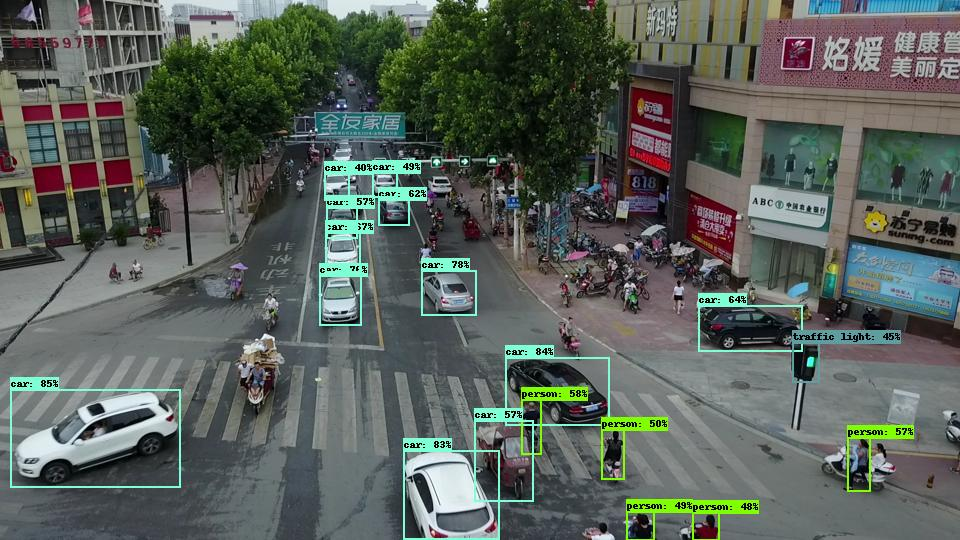

In [17]:
from IPython import display
display.display(display.Image(os.path.join(serve_image_out, '0.jpg')))

In [26]:
# # In case you need to specify different image size or batch size or #boxes, then
# # you need to export a new saved model and run the inferernce.

# serve_image_out = 'serve_image_out'
# !rd /s /q {serve_image_out}
# saved_model_dir = 'savedmodel'
# !rd /s /q {saved_model_dir}

# # Step 1: export model
# !python model_inspect.py --runmode=saved_model \
#   --model_name=efficientdet-d0 --ckpt_path=efficientdet-d0 \
#   --hparams="image_size=1920x1280" --saved_model_dir={saved_model_dir}

# # Step 2: do inference with saved model.
# !python model_inspect.py --runmode=saved_model_infer \
#   --model_name=efficientdet-d0 --saved_model_dir={saved_model_dir} \
#   --input_image=testagain.jpg --output_image_dir={serve_image_out} \
#   --min_score_thresh={min_score_thresh}  --max_boxes_to_draw={max_boxes_to_draw}

# from IPython import display
# display.display(display.Image(os.path.join(serve_image_out, '0.jpg')))

The system cannot find the file specified.
2021-10-28 17:07:40.747162: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-28 17:07:42.079392: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3989 MB memory:  -> device: 0, name: GeForce GTX 1660 Ti with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5

W1028 17:07:43.373433 11196 module_wrapper.py:153] From d:\codingan_serius\bachelor_thesis\colab\automl\efficientdet\utils.py:601: The name tf.keras.layers.enable_v2_dtype_behavior is deprecated. Please use tf.compat.v1.keras.layers.enable_v2_dtype_behavior instead.

Instructions for updating:
Use Variable.read_value. Variables in 2.X a

all_files= []


2021-10-28 17:09:13.307434: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-28 17:09:14.654115: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3989 MB memory:  -> device: 0, name: GeForce GTX 1660 Ti with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
W1028 17:09:14.656644  1860 deprecation.py:339] From d:\codingan_serius\bachelor_thesis\colab\automl\efficientdet\inference.py:569: l

FileNotFoundError: No such file or directory: 'serve_image_out\0.jpg'

FileNotFoundError: No such file or directory: 'serve_image_out\0.jpg'

<IPython.core.display.Image object>

## 1.4 Inference video

In [ ]:
# # step 0: download video
# video_url = 'https://storage.googleapis.com/cloud-tpu-checkpoints/efficientdet/data/video480p.mov'  # @param
# !wget {video_url} -O input.mov

# # Step 1: export model
# saved_model_dir = 'savedmodel'
# !rm -rf {saved_model_dir}

# !python model_inspect.py --runmode=saved_model \
#   --model_name=efficientdet-d0 --ckpt_path=efficientdet-d0 \
#   --saved_model_dir={saved_model_dir} --hparams="mixed_precision=true"

# # Step 2: do inference with saved model using saved_model_video
# !python model_inspect.py --runmode=saved_model_video \
#   --model_name=efficientdet-d0   --ckpt_path=efficientdet-d0 \
#   --saved_model_dir={saved_model_dir} --hparams="mixed_precision=true" \
#   --input_video=input.mov --output_video=output.mov
# # Then you can view the output.mov

--2020-06-01 05:08:08--  https://storage.googleapis.com/cloud-tpu-checkpoints/efficientdet/data/video480p.mov
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.204.128, 2607:f8b0:400c:c05::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18511760 (18M) [application/octet-stream]
Saving to: ‘input.mov’

input.mov           100%[===================>]  17.65M  --.-KB/s    in 0.1s    

2020-06-01 05:08:08 (119 MB/s) - ‘input.mov’ saved [18511760/18511760]

2020-06-01 05:08:10.640913: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-06-01 05:08:12.964736: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2300000000 Hz
2020-06-01 05:08:12.965102: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x2c41480 initialized for platform Host (this does not guarantee t

# 3. COCO evaluation

## 3.1 COCO evaluation on validation set.

In [ ]:
# if 'val2017' not in os.listdir():
#   !wget http://images.cocodataset.org/zips/val2017.zip
#   !wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
#   !unzip -q val2017.zip
#   !unzip annotations_trainval2017.zip

#   !mkdir tfrecord
#   !PYTHONPATH=".:$PYTHONPATH"  python dataset/create_coco_tfrecord.py \
#       --image_dir=val2017 \
#       --caption_annotations_file=annotations/captions_val2017.json \
#       --output_file_prefix=tfrecord/val \
#       --num_shards=32

--2020-06-01 03:22:59--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.239.115
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.239.115|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  95.2MB/s    in 8.1s    

2020-06-01 03:23:07 (96.1 MB/s) - ‘val2017.zip’ saved [815585330/815585330]

--2020-06-01 03:23:08--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.163.67
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.163.67|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  96.2MB/s    in 2.5s    

2020

In [ ]:
# # Evalute on validation set (takes about 10 mins for efficientdet-d0)
# !python main.py --mode=eval  \
#     --model_name={MODEL}  --model_dir={ckpt_path}  \
#     --val_file_pattern=tfrecord/val*  \
#     --val_json_file=annotations/instances_val2017.json

2020-06-01 03:28:25.377482: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1

W0601 03:28:27.532853 140219029243776 module_wrapper.py:138] From main.py:234: The name tf.estimator.tpu.TPUConfig is deprecated. Please use tf.compat.v1.estimator.tpu.TPUConfig instead.


W0601 03:28:27.533198 140219029243776 module_wrapper.py:138] From main.py:239: The name tf.estimator.tpu.InputPipelineConfig is deprecated. Please use tf.compat.v1.estimator.tpu.InputPipelineConfig instead.


W0601 03:28:27.533394 140219029243776 module_wrapper.py:138] From main.py:247: The name tf.estimator.tpu.RunConfig is deprecated. Please use tf.compat.v1.estimator.tpu.RunConfig instead.

I0601 03:28:27.533618 140219029243776 main.py:262] {'name': 'efficientdet-d0', 'act_type': 'swish', 'image_size': (512, 512), 'target_size': None, 'input_rand_hflip': True, 'train_scale_min': 0.1, 'train_scale_max': 2.0, 'autoaugment_policy': None, 'use_augmix': Fals

## 3.2 COCO evaluation on test-dev.

In [ ]:
# # Eval on test-dev is slow (~40 mins), please be cautious. 
# RUN_EXPENSIVE_TEST_DEV_EVAL = True  #@param

# if RUN_EXPENSIVE_TEST_DEV_EVAL == True:
#   !rm *.zip *.tar tfrecord/ val2017/   # Cleanup disk space
#   # Download and convert test-dev data.
#   if "test2017" not in os.listdir():
#     !wget http://images.cocodataset.org/zips/test2017.zip
#     !unzip -q test2017.zip
#     !wget http://images.cocodataset.org/annotations/image_info_test2017.zip
#     !unzip image_info_test2017.zip

#     !mkdir tfrecord
#     !PYTHONPATH=".:$PYTHONPATH"  python dataset/create_coco_tfrecord.py \
#           --image_dir=test2017 \
#           --image_info_file=annotations/image_info_test-dev2017.json \
#           --output_file_prefix=tfrecord/testdev \
#           --num_shards=32

#   # Evalute on validation set: non-empty testdev_dir is the key pararmeter.
#   # Also, test-dev has 20288 images rather than val 5000 images.
#   !mkdir testdev_output
#   !python main.py --mode=eval  \
#       --model_name={MODEL}  --model_dir={ckpt_path}  \
#       --val_file_pattern=tfrecord/testdev*  \
#       --eval_batch_size=8  --eval_samples=20288 \
#       --testdev_dir='testdev_output'
#   !rm -rf test2017  # delete images to release disk space.
#   # Now you can submit testdev_output/detections_test-dev2017_test_results.json to
#   # coco server: https://competitions.codalab.org/competitions/20794#participate

# 4. Training EfficientDets on VisDrone.

## 4.1 Prepare data

In [14]:
  # #the flag is from pascal VOC, but the .py is already modified
  # # !python dataset/create_visdrone_tfrecord.py  \
  # #   --data_dir=VOCdevkit --year=VOC2012  --output_path=tfrecord_drone_new/visdrone

  # !python dataset/create_visdrone_tfrecord.py  --data_dir=D:/codingan_serius/bachelor_thesis/Tensorflow/VisDrone2019-DET-train  \
  #   --year=VOC2012 --output_path=./tfrecord_drone_new/train/

example 0000002_00005_d_0000014.xml
example 0000002_00448_d_0000015.xml
example 0000003_00231_d_0000016.xml
example 0000007_04999_d_0000036.xml
example 0000007_05499_d_0000037.xml
example 0000007_05999_d_0000038.xml
example 0000008_00889_d_0000039.xml
example 0000008_01999_d_0000040.xml
example 0000008_02499_d_0000041.xml
example 0000008_02999_d_0000042.xml
example 0000008_03499_d_0000043.xml
example 0000008_03999_d_0000044.xml
example 0000008_04499_d_0000045.xml
example 0000010_00569_d_0000056.xml
example 0000010_05149_d_0000057.xml
example 0000010_05291_d_0000058.xml
example 0000013_00465_d_0000067.xml
example 0000016_00420_d_0000068.xml
example 0000016_01352_d_0000069.xml
example 0000030_00754_d_0000036.xml
example 0000031_00000_d_0000037.xml
example 0000031_02000_d_0000041.xml
example 0000031_03527_d_0000043.xml
example 0000036_00500_d_0000046.xml
example 0000036_03591_d_0000048.xml
example 0000037_01494_d_0000052.xml
example 0000039_00000_d_0000055.xml
example 0000039_05300_d_0000

I1104 09:14:35.637770 16532 create_visdrone_tfrecord.py:227] writing to output path: ./tfrecord_drone_new/train/
I1104 09:14:35.643808 16532 create_visdrone_tfrecord.py:251] Reading from PASCAL VOC2012 dataset.
I1104 09:14:35.651775 16532 create_visdrone_tfrecord.py:266] On image 0 of 6471
I1104 09:14:37.802075 16532 create_visdrone_tfrecord.py:266] On image 100 of 6471
I1104 09:14:39.281941 16532 create_visdrone_tfrecord.py:266] On image 200 of 6471
I1104 09:14:41.670863 16532 create_visdrone_tfrecord.py:266] On image 300 of 6471
I1104 09:14:44.095864 16532 create_visdrone_tfrecord.py:266] On image 400 of 6471
I1104 09:14:46.466562 16532 create_visdrone_tfrecord.py:266] On image 500 of 6471
I1104 09:14:49.446505 16532 create_visdrone_tfrecord.py:266] On image 600 of 6471
I1104 09:14:51.340316 16532 create_visdrone_tfrecord.py:266] On image 700 of 6471
I1104 09:14:53.550752 16532 create_visdrone_tfrecord.py:266] On image 800 of 6471
I1104 09:14:55.778296 16532 create_visdrone_tfrecord.


example 0000008_03999_d_0000044.xml
example 0000008_04499_d_0000045.xml
example 0000010_00569_d_0000056.xml
example 0000010_05149_d_0000057.xml

example 0000010_05291_d_0000058.xml
example 0000013_00465_d_0000067.xml
example 0000016_00420_d_0000068.xml
example 0000016_01352_d_0000069.xml
example 0000030_00754_d_0000036.xml
example 0000031_00000_d_0000037.xml
example 0000031_02000_d_0000041.xml
example 0000031_03527_d_0000043.xml
example 0000036_00500_d_0000046.xml
example 0000133_00078_d_0000141.xml
example 0000133_00480_d_0000142.xml
example 0000133_00846_d_0000143.xml
example 0000036_03591_d_0000048.xml
example 0000037_01494_d_0000052.xml
example 0000039_00000_d_0000055.xml
example 0000039_05300_d_0000061.xml
example 0000039_05625_d_0000062.xml
example 0000040_01000_d_0000066.xml
example 0000040_01500_d_0000067.xml
example 0000040_02454_d_0000068.xml
example 0000040_03288_d_0000069.xml
example 0000040_03752_d_0000070.xml
example 0000040_04284_d_0000071.xml
example 0000042_01000_d_00

I1104 09:16:32.399884 11028 create_visdrone_tfrecord.py:266] On image 1600 of 6471
I1104 09:16:36.174229 11028 create_visdrone_tfrecord.py:266] On image 1700 of 6471
I1104 09:16:40.729384 11028 create_visdrone_tfrecord.py:266] On image 1800 of 6471
I1104 09:16:45.039386 11028 create_visdrone_tfrecord.py:266] On image 1900 of 6471
I1104 09:16:49.022305 11028 create_visdrone_tfrecord.py:266] On image 2000 of 6471
I1104 09:16:53.103040 11028 create_visdrone_tfrecord.py:266] On image 2100 of 6471
I1104 09:16:56.514390 11028 create_visdrone_tfrecord.py:266] On image 2200 of 6471
I1104 09:17:00.503983 11028 create_visdrone_tfrecord.py:266] On image 2300 of 6471
I1104 09:17:03.751251 11028 create_visdrone_tfrecord.py:266] On image 2400 of 6471
I1104 09:17:07.187044 11028 create_visdrone_tfrecord.py:266] On image 2500 of 6471
I1104 09:17:09.828921 11028 create_visdrone_tfrecord.py:266] On image 2600 of 6471
I1104 09:17:13.460117 11028 create_visdrone_tfrecord.py:266] On image 2700 of 6471
I110

example 0000072_05285_d_0000006.xml
example 0000072_05564_d_0000007.xml
example 0000072_05654_d_0000008.xml
example 0000072_05827_d_0000009.xml
example 0000072_06173_d_0000010.xml
example 0000072_07242_d_0000011.xml
example 0000072_07660_d_0000012.xml
example 0000072_08702_d_0000013.xml
example 0000072_09163_d_0000014.xml
example 0000076_00004_d_0000001.xml
example 0000076_00352_d_0000002.xml
example 0000076_00616_d_0000003.xml
example 0000156_00354_d_0000078.xml
example 0000156_00554_d_0000079.xml
example 0000157_00251_d_0000081.xml
example 0000157_00451_d_0000082.xml
example 0000157_00651_d_0000083.xml
example 0000165_00125_d_0000084.xml
example 0000165_00525_d_0000086.xml
example 0000165_00725_d_0000087.xml
example 0000165_00925_d_0000088.xml
example 0000165_01325_d_0000090.xml

example 0000165_01525_d_0000091.xml
example 0000165_01725_d_0000092.xml
example 0000165_02125_d_0000094.xml
example 0000165_02725_d_0000097.xml
example 0000165_02925_d_0000098.xml
example 0000165_03325_d_000

## 4.2 Train VisDrone from ImageNet checkpoint for Backbone.

In [6]:
# Pascal has 5717 train images with 100 shards epoch, here we use a single shard
# for demo, but users should use all shards pascal-*-of-00100.tfrecord.
file_pattern = '-*-of-00100.tfrecord'  # @param
images_per_epoch = 57 * len(tf.io.gfile.glob('train/' + file_pattern))

images_per_epoch = images_per_epoch // 8 * 8  # round to 64.
print('images_per_epoch = {}'.format(images_per_epoch))

images_per_epoch = 5696


In [7]:
# Train efficientdet from scratch with backbone checkpoint.
backbone_name = {
    'efficientdet-d0': 'efficientnet-b0',
    'efficientdet-d1': 'efficientnet-b1',
    'efficientdet-d2': 'efficientnet-b2',
    'efficientdet-d3': 'efficientnet-b3',
    'efficientdet-d4': 'efficientnet-b4',
    'efficientdet-d5': 'efficientnet-b5',
    'efficientdet-d6': 'efficientnet-b6',
    'efficientdet-d7': 'efficientnet-b6',
}[MODEL]


# generating train tfrecord is large, so we skip the execution here.
import os
if backbone_name not in os.listdir():
  print("trying download and extract")
  !wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/ckptsaug/{backbone_name}.tar.gz
  !tar zxf {backbone_name}.tar.gz

#file_pattern_new='D:/codingan_serius/bachelor_thesis/Tensorflow/workspace/data/train.tfrecord'
#!mkdir /tmp/model_dir/
# key option: use --backbone_ckpt rather than --ckpt.
# Don't use ema since we only train a few steps.
# num class tadinya 11 sekarang 12, terus ganti 10 kwkwk
!python3 main.py --mode=train_and_eval \
    --train_file_pattern=train/{file_pattern} \
    --val_file_pattern=train/{file_pattern} \
    --model_name={MODEL} \
    --model_dir=../model_dir/{MODEL}-scratch-ep600-adam \
    --backbone_ckpt={backbone_name} \
    --train_batch_size=1 \
    --eval_batch_size=1 --eval_samples={images_per_epoch}  \
    --num_examples_per_epoch={images_per_epoch}  --num_epochs=600  \
    --hparams="num_classes=10,moving_average_decay=0,mixed_precision=true,max_instances_per_image={images_per_epoch+1}"

2022-03-24 11:50:11.267290: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-24 11:50:11.292941: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-24 11:50:11.293131: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
I0324 11:50:11.293583 139894976857920 main.py:228] {'name': 'efficientdet-d0', 'act_type': 'swish', 'image_size': (512, 512), 'target_size': None, 'input_rand_hflip': True, 'jitter_min': 0.1, 'jitter_max': 2.0, 'autoaugment_policy': None, 'grid_mask': False, 'sample_image': None, 'map_freq': 5, 'num_classes': 10, 'seg_num_classes': 3, 'he

## 4.3 Train PASCAL VOC 2012 from COCO checkpoint for the whole net.

In [1]:
# generating train tfrecord is large, so we skip the execution here.
import os
if MODEL not in os.listdir():
  !wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientdet/coco/{MODEL}.tar.gz
  !tar xf {MODEL}.tar.gz

file_pattern_new='D:/codingan_serius/bachelor_thesis/Tensorflow/workspace/data/train.tfrecord'

!mkdir /tmp/model_dir/
# key option: use --ckpt rather than --backbone_ckpt.
!python main.py --mode=train_and_eval \
    --train_file_pattern=tfrecord/{file_pattern} \
    --val_file_pattern=tfrecord/{file_pattern} \
    --model_name={MODEL} \
    --model_dir=/tmp/model_dir/{MODEL}-finetune \
    --ckpt={MODEL} \
    --train_batch_size=8 \
    --eval_batch_size=8 --eval_samples={images_per_epoch}  \
    --num_examples_per_epoch={images_per_epoch}  --num_epochs=1  \
    --hparams="num_classes=20,moving_average_decay=0,mixed_precision=true"

NameError: name 'MODEL' is not defined

## 4.4 View tensorboard for loss and accuracy.


In [5]:
%load_ext tensorboard
%tensorboard --logdir ../model_dir/
# Notably, this is just a demo with almost zero accuracy due to very limited
# training steps, but we can see finetuning has smaller loss than training
# from scratch at the begining.

# 5. Start Trying 

In [3]:
MODEL

'efficientdet-d0'

In [21]:
# first export a saved model.
ckpt_path = '/home/iga/bachelor_thesis/colab/automl/model_dir/efficientdet-d0-scratch-ep10-sgd'
saved_model_dir='/home/iga/bachelor_thesis/colab/automl/saved_own_model_new'
#!rm -rf {saved_model_dir} 
#--model_name={MODEL} --model_name=efficientdet-d0-scratch-epo50 
!python3 model_inspect.py --runmode=saved_model --model_name={MODEL} \
  --ckpt_path={ckpt_path} --saved_model_dir={saved_model_dir} --hparams="num_classes=10,moving_average_decay=0,mixed_precision=true"

2022-01-31 17:35:55.767631: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-31 17:35:56.477093: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-31 17:35:56.477825: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-31 17:35:56.557530: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [22]:
# Then run saved_model_infer to do inference.
# Notably: batch_size, image_size must be the same as when it is exported.
serve_image_out = 'serve_fixed_image_out'
!mkdir {serve_image_out}

!python3 model_inspect.py --runmode=saved_model_infer \
  --saved_model_dir={saved_model_dir} \
  --model_name={MODEL}  --input_image=testdata/testagain.jpg  \
  --output_image_dir={serve_image_out} \
  --min_score_thresh={min_score_thresh}  --max_boxes_to_draw={max_boxes_to_draw} --hparams="num_classes=10,moving_average_decay=0,mixed_precision=true"

mkdir: cannot create directory ‘serve_fixed_image_out’: File exists
2022-01-31 17:36:22.030984: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-31 17:36:22.075152: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-31 17:36:22.075390: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-31 17:36:22.076348: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in othe

In [24]:
from IPython import display
display.display(display.Image(os.path.join(serve_image_out, 'testagain.jpg')))

FileNotFoundError: No such file or directory: 'serve_fixed_image_out/testagain.jpg'

FileNotFoundError: No such file or directory: 'serve_fixed_image_out/testagain.jpg'

<IPython.core.display.Image object>